xT grid dimensions: 8 12

Disruption impact analysis saved to 'match_analysis_results.xlsx' in the 'Disruption Impact' sheet.


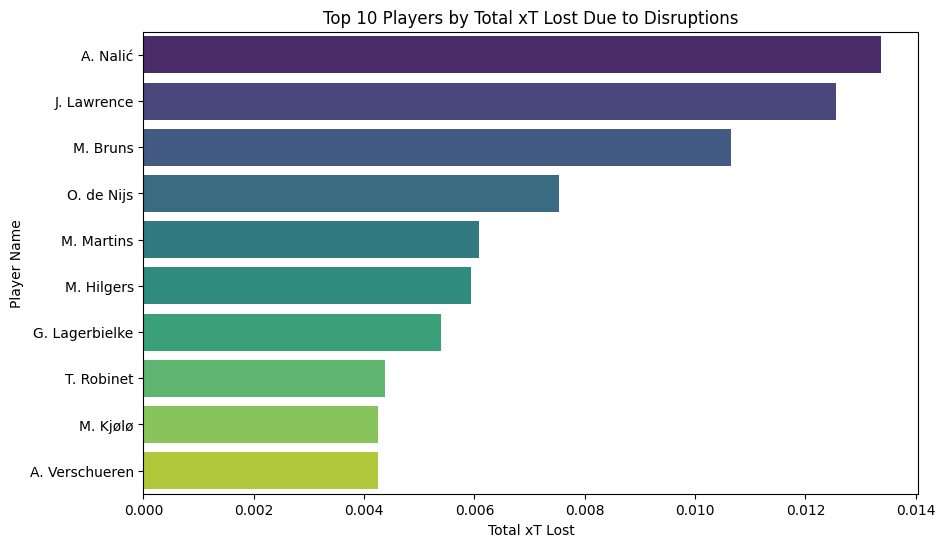

In [36]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import atan2

# Step 1: Load and Prepare the Data
# Load the main data from the CSV file
df = pd.read_csv("/Users/marclambertes/Python/Matches/Men/2024-2025/Eredivisie 2024-2025/Twente 1-0 Almere.csv")
type_cols = [col for col in df.columns if '/qualifierId' in col]

# Initialize 'endX' and 'endY' columns with 0.0
df['endX'] = 0.0
df['endY'] = 0.0
# Step 2: Load xT Grid
xT = pd.read_csv("xT_grid.csv", header=None)
xT = np.array(xT)
xT_rows, xT_cols = xT.shape
print("xT grid dimensions:", xT_rows, xT_cols)

# Step 3: Bin Coordinates into xT Grid Zones
df['x1_bin'] = pd.cut(df['x'], bins=xT_cols, labels=False)
df['y1_bin'] = pd.cut(df['y'], bins=xT_rows, labels=False)
df['x2_bin'] = pd.cut(df['endX'], bins=xT_cols, labels=False)
df['y2_bin'] = pd.cut(df['endY'], bins=xT_rows, labels=False)

# Step 4: Calculate xT for Each Pass
df['start_zone_value'] = df.apply(lambda row: xT[row['y1_bin'], row['x1_bin']], axis=1)
df['end_zone_value'] = df.apply(lambda row: xT[row['y2_bin'], row['x2_bin']], axis=1)
df['xT'] = df['end_zone_value'] - df['start_zone_value']

# Step 5: Calculate xPass for Each Pass
df['distance'] = np.sqrt((df['endX'] - df['x']) ** 2 + (df['endY'] - df['y']) ** 2)
df['angle'] = np.abs(np.arctan2(df['endY'] - df['y'], df['endX'] - df['x']))
df['xPass'] = 1 - (0.02 * df['distance'] + 0.1 * df['angle'])
df['xPass'] = df['xPass'].clip(0, 1)  # Clip xPass to be between 0 and 1

# Step 6: Identify Defensive Interventions
defensive_actions = ['7', '8']  # Replace with actual event type IDs for defensive actions
df['defensive_intervention'] = df['typeId'].astype(str).isin(defensive_actions)

# Step 7: Add xT and xPass Lost for Disrupted Passes
df['xT_lost'] = df.apply(lambda row: row['xT'] if row['defensive_intervention'] else 0, axis=1)
df['xPass_lost'] = df.apply(lambda row: row['xPass'] if row['defensive_intervention'] else 0, axis=1)

# Step 8: Aggregate xT and xPass Lost by Player
player_disruption = df.groupby(['playerName', 'contestantId']).agg(
    total_disruptions=('defensive_intervention', 'sum'),
    total_xT_lost=('xT_lost', 'sum'),
    total_xPass_lost=('xPass_lost', 'sum')
).reset_index()

# Calculate xT and xPass lost per disruption
player_disruption['xT_lost_per_disruption'] = (
    player_disruption['total_xT_lost'] / player_disruption['total_disruptions']
)
player_disruption['xPass_lost_per_disruption'] = (
    player_disruption['total_xPass_lost'] / player_disruption['total_disruptions']
)

# Sort by total xT lost (most impactful disruptors)
player_disruption = player_disruption.sort_values(by='total_xT_lost', ascending=False)

# Step 9: Save Results to Excel
with pd.ExcelWriter("match_analysis_results.xlsx", mode="a", engine="openpyxl") as writer:
    player_disruption.to_excel(writer, sheet_name="Disruption Impact", index=False)

print("\nDisruption impact analysis saved to 'match_analysis_results.xlsx' in the 'Disruption Impact' sheet.")

# Step 10: Visualize the Results
# Plot top 10 players by total xT lost
top_10_xT_lost = player_disruption.head(10)

plt.figure(figsize=(10, 6))
sns.barplot(
    x='total_xT_lost', 
    y='playerName', 
    data=top_10_xT_lost, 
    palette='viridis'
)
plt.title('Top 10 Players by Total xT Lost Due to Disruptions')
plt.xlabel('Total xT Lost')
plt.ylabel('Player Name')
plt.show()

/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_39763/3010875078.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.pass_angle[i] = angle
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_39763/3010875078.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.pass_length[i] = length


Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       341
           1       0.00      0.00      0.00        16

    accuracy                           0.96       357
   macro avg       0.48      0.50      0.49       357
weighted avg       0.91      0.96      0.93       357

ROC AUC Score: 0.5705645161290323


/Users/marclambertes/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/marclambertes/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/marclambertes/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


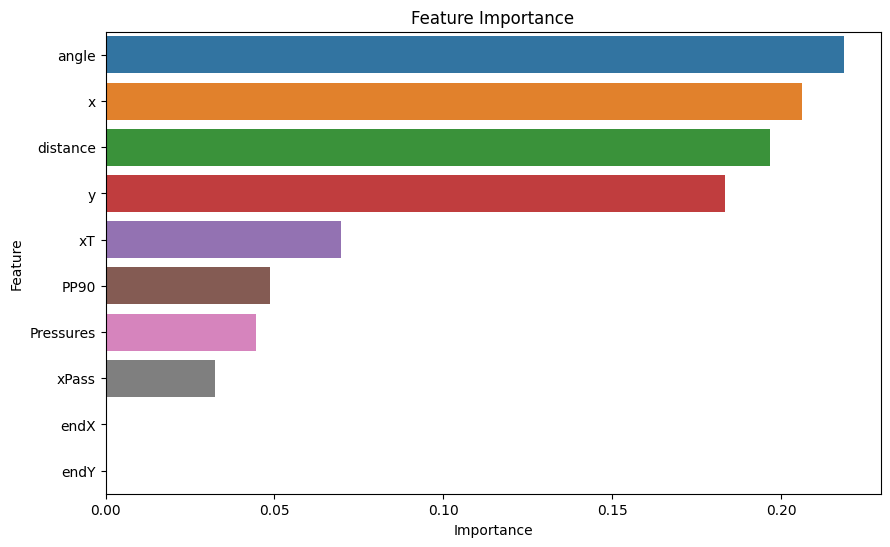


Model saved as 'disruption_model.pkl'.


In [59]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load and Prepare the Data
df = pd.read_csv("/Users/marclambertes/Python/Matches/Men/2024-2025/Eredivisie 2024-2025/Twente 1-0 Almere.csv")
type_cols = [col for col in df.columns if '/qualifierId' in col]

# Initialize 'endX', 'endY', 'pass_angle', and 'pass_length' columns with 0.0
df['endX'] = 0.0
df['endY'] = 0.0
df['pass_angle'] = 0.0
df['pass_length'] = 0.0

# Step 3: Extract 'endX', 'endY', 'pass_angle', and 'pass_length' from qualifiers
for i in range(len(df)):
    df1 = df.iloc[i:i+1, :]
    for j in range(len(type_cols)):
        col = df1[type_cols[j]].values[0]
        if col == 140:  # Qualifier ID for endX
            endx = df1.loc[:, 'qualifier/%i/value' % j].values[0]
            df.at[i, 'endX'] = endx
        elif col == 141:  # Qualifier ID for endY
            endy = df1.loc[:, 'qualifier/%i/value' % j].values[0]
            df.at[i, 'endY'] = endy
        elif col == 213:  # Qualifier ID for pass angle
            angle = df1.loc[:, 'qualifier/%i/value' % j].values[0]
            df.at[i, 'pass_angle'] = angle
        elif col == 212:  # Qualifier ID for pass length
            length = df1.loc[:, 'qualifier/%i/value' % j].values[0]
            df.at[i, 'pass_length'] = length
# Step 2: Convert columns to numeric and handle missing/invalid data
numeric_cols = ['x', 'y', 'endX', 'endY', 'pass_length', 'pass_angle']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert to numeric, invalid -> NaN

# Drop rows with missing values in numeric columns
df = df.dropna(subset=numeric_cols)

# Step 3: Feature Engineering
# Load xT grid
xT = pd.read_csv("xT_grid.csv", header=None)
xT = np.array(xT)
xT_rows, xT_cols = xT.shape

# Bin coordinates into xT grid zones
df['x1_bin'] = pd.cut(df['x'], bins=xT_cols, labels=False)
df['y1_bin'] = pd.cut(df['y'], bins=xT_rows, labels=False)
df['x2_bin'] = pd.cut(df['endX'], bins=xT_cols, labels=False)
df['y2_bin'] = pd.cut(df['endY'], bins=xT_rows, labels=False)

# Calculate xT and xPass
df['start_zone_value'] = df.apply(lambda row: xT[row['y1_bin'], row['x1_bin']], axis=1)
df['end_zone_value'] = df.apply(lambda row: xT[row['y2_bin'], row['x2_bin']], axis=1)
df['xT'] = df['end_zone_value'] - df['start_zone_value']

df['distance'] = np.sqrt((df['endX'] - df['x']) ** 2 + (df['endY'] - df['y']) ** 2)
df['angle'] = np.abs(np.arctan2(df['endY'] - df['y'], df['endX'] - df['x']))
df['xPass'] = 1 - (0.02 * df['distance'] + 0.1 * df['angle'])
df['xPass'] = df['xPass'].clip(0, 1)

# Step 4: Define Target Variable
df['defensive_intervention'] = df['typeId'].astype(str).isin(['7', '8']).astype(int)  # Adjust typeId as needed

# Step 5: Pressing Events Analysis
# Define event type IDs
PASS_EVENTS = {1}  # Adjust if needed
PRESSING_EVENTS = {7, 8, 44, 45, 49}

# Sort events by period, time, and sequence
df = df.sort_values(by=["periodId", "timeMin", "timeSec"])

# Shift previous event details (for contestantId and typeId)
df["prev_contestantId"] = df["contestantId"].shift(1)
df["prev_typeId"] = df["typeId"].shift(1)

# Filter pressing events where the previous event was a pass by the other team
pressing_events = df[
    (df["typeId"].isin(PRESSING_EVENTS)) & 
    (df["prev_typeId"].isin(PASS_EVENTS)) & 
    (df["contestantId"] != df["prev_contestantId"])  # Different team
]

# Count pressing events by player
pressing_count = pressing_events.groupby(["contestantId", "playerName"])["id"].count().reset_index()
pressing_count.rename(columns={"id": "Pressures"}, inplace=True)


# Calculate Pressures per 90 minutes (PP90)
total_minutes = df["timeMin"].max()  # Assuming match is complete
pressing_count["PP90"] = (pressing_count["Pressures"] / total_minutes) * 90

# Step 6: Merge Pressing Events Data with Main DataFrame
df = df.merge(pressing_count[["playerName", "Pressures", "PP90"]], on="playerName", how="left")

# Fill missing values in Pressures and PP90 (for players with no pressing events)
df['Pressures'] = df['Pressures'].fillna(0)
df['PP90'] = df['PP90'].fillna(0)

# Step 7: Select Features and Target
features = ['xT', 'xPass', 'distance', 'angle', 'x', 'y', 'endX', 'endY', 'Pressures', 'PP90']
X = df[features]
y = df['defensive_intervention']

# Step 8: Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 9: Train a Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 10: Evaluate the Model
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of disruption

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))

# Step 11: Feature Importance
feature_importances = pd.Series(model.feature_importances_, index=features)
feature_importances.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Step 12: Save the Model
import joblib
joblib.dump(model, "disruption_model.pkl")

print("\nModel saved as 'disruption_model.pkl'.")

xT grid dimensions: 8 12
Loading file: PSV 3-0 Go Ahead.csv
Loading file: Almere 3-0 Heerenveen.csv
Loading file: Waalwijk 2-0 Almere.csv
Loading file: Twente 2-0 Groningen.csv
Loading file: Sparta 0-0 Heracles.csv
Loading file: Heracles 2-2 Waalwijk.csv
Loading file: PSV 3-0 Feyenoord.csv
Loading file: Willem II 2-2 NAC.csv
Loading file: Twente 3-2 Go Ahead.csv
Loading file: Willem II 1-1 Feyenoord.csv
Loading file: PSV 6-1 Twente.csv
Loading file: NEC 2-2 Almere.csv
Loading file: PSV 6-0 Zwolle.csv
Loading file: Almere 1-3 Utrecht.csv
Loading file: Fortuna 1-0 AZ.csv
Loading file: Feyenoord 3-0 Heerenveen.csv
Loading file: Go Ahead 2-2 Twente.csv
Loading file: Zwolle 1-0 Almere.csv
Loading file: Heracles 1-1 Willem II.csv
Loading file: Utrecht 0-1 Almere.csv
Loading file: Ajax 3-2 PSV.csv
Loading file: NEC 3-0 Heerenveen.csv
Loading file: Ajax 2-1 Waalwijk.csv
Loading file: Almere 1-4 Waalwijk.csv
Loading file: NAC 1-0 Almere.csv
Loading file: AZ 1-0 Twente.csv
Loading file: PSV 2-1 

Loading file: AZ 1-0 Heracles.csv
Loading file: Almere 0-2 Heracles.csv

All files combined into a single DataFrame.
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     78695
           1       0.23      0.03      0.05      2363

    accuracy                           0.97     81058
   macro avg       0.60      0.51      0.52     81058
weighted avg       0.95      0.97      0.96     81058

ROC AUC Score: 0.9054410744976973


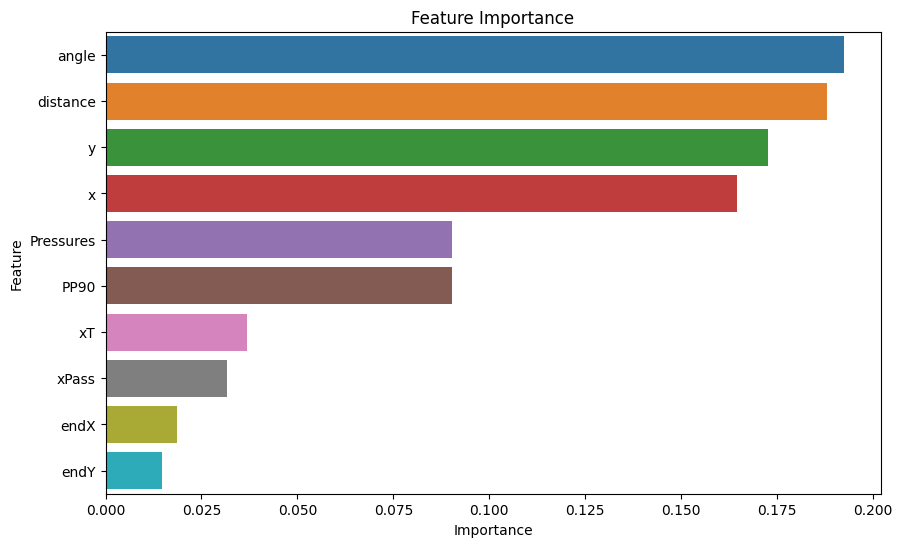


Model saved as 'disruption_model_combined.pkl'.


In [66]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib

# Step 1: Define the folder containing CSV files
folder_path = "/Users/marclambertes/Python/Matches/Men/2024-2025/Eredivisie 2024-2025"

# Step 2: Load xT Grid
xT = pd.read_csv("xT_grid.csv", header=None)
xT = np.array(xT)
xT_rows, xT_cols = xT.shape
print("xT grid dimensions:", xT_rows, xT_cols)

# Step 3: Combine all CSV files into one DataFrame
all_data = pd.DataFrame()

for file_name in os.listdir(folder_path):
    if file_name.endswith(".csv"):
        print(f"Loading file: {file_name}")
        file_path = os.path.join(folder_path, file_name)
        df = pd.read_csv(file_path)
        all_data = pd.concat([all_data, df], ignore_index=True)

print("\nAll files combined into a single DataFrame.")

# Step 4: Process Qualifiers for 'endX', 'endY', 'pass_angle', and 'pass_length'
type_cols = [col for col in all_data.columns if '/qualifierId' in col]

# Initialize 'endX', 'endY', 'pass_angle', and 'pass_length' columns with 0.0
all_data['endX'] = 0.0
all_data['endY'] = 0.0
all_data['pass_angle'] = 0.0
all_data['pass_length'] = 0.0

# Extract values from qualifiers
for i in range(len(all_data)):
    df1 = all_data.iloc[i:i+1, :]
    for j in range(len(type_cols)):
        col = df1[type_cols[j]].values[0]
        if col == 140:  # Qualifier ID for endX
            endx = df1.loc[:, 'qualifier/%i/value' % j].values[0]
            all_data.at[i, 'endX'] = endx
        elif col == 141:  # Qualifier ID for endY
            endy = df1.loc[:, 'qualifier/%i/value' % j].values[0]
            all_data.at[i, 'endY'] = endy
        elif col == 213:  # Qualifier ID for pass angle
            angle = df1.loc[:, 'qualifier/%i/value' % j].values[0]
            all_data.at[i, 'pass_angle'] = angle
        elif col == 212:  # Qualifier ID for pass length
            length = df1.loc[:, 'qualifier/%i/value' % j].values[0]
            all_data.at[i, 'pass_length'] = length

# Step 5: Clean and prepare the data
# Convert columns to numeric and handle missing/invalid data
numeric_cols = ['x', 'y', 'endX', 'endY', 'pass_length', 'pass_angle']
for col in numeric_cols:
    all_data[col] = pd.to_numeric(all_data[col], errors='coerce')  # Convert to numeric, invalid -> NaN

# Drop rows with missing values in numeric columns
all_data = all_data.dropna(subset=numeric_cols)

# Step 6: Feature Engineering
# Bin coordinates into xT grid zones
all_data['x1_bin'] = pd.cut(all_data['x'], bins=xT_cols, labels=False)
all_data['y1_bin'] = pd.cut(all_data['y'], bins=xT_rows, labels=False)
all_data['x2_bin'] = pd.cut(all_data['endX'], bins=xT_cols, labels=False)
all_data['y2_bin'] = pd.cut(all_data['endY'], bins=xT_rows, labels=False)

# Calculate xT and xPass
all_data['start_zone_value'] = all_data.apply(lambda row: xT[row['y1_bin'], row['x1_bin']], axis=1)
all_data['end_zone_value'] = all_data.apply(lambda row: xT[row['y2_bin'], row['x2_bin']], axis=1)
all_data['xT'] = all_data['end_zone_value'] - all_data['start_zone_value']

all_data['distance'] = np.sqrt((all_data['endX'] - all_data['x']) ** 2 + (all_data['endY'] - all_data['y']) ** 2)
all_data['angle'] = np.abs(np.arctan2(all_data['endY'] - all_data['y'], all_data['endX'] - all_data['x']))
all_data['xPass'] = 1 - (0.02 * all_data['distance'] + 0.1 * all_data['angle'])
all_data['xPass'] = all_data['xPass'].clip(0, 1)

# Step 7: Define Target Variable
all_data['defensive_intervention'] = all_data['typeId'].astype(str).isin(['7', '8']).astype(int)

# Step 8: Pressing Events Analysis
# Define event type IDs
PASS_EVENTS = {1}  # Adjust if needed
PRESSING_EVENTS = {7, 8, 44, 45, 49}

# Sort events by period, time, and sequence
all_data = all_data.sort_values(by=["periodId", "timeMin", "timeSec"])

# Shift previous event details (for contestantId and typeId)
all_data["prev_contestantId"] = all_data["contestantId"].shift(1)
all_data["prev_typeId"] = all_data["typeId"].shift(1)

# Filter pressing events where the previous event was a pass by the other team
pressing_events = all_data[
    (all_data["typeId"].isin(PRESSING_EVENTS)) & 
    (all_data["prev_typeId"].isin(PASS_EVENTS)) & 
    (all_data["contestantId"] != all_data["prev_contestantId"])  # Different team
]

# Count pressing events by player
pressing_count = pressing_events.groupby(["contestantId", "playerName"])["id"].count().reset_index()
pressing_count.rename(columns={"id": "Pressures"}, inplace=True)

# Calculate Pressures per 90 minutes (PP90)
total_minutes = all_data["timeMin"].max()  # Assuming match is complete
pressing_count["PP90"] = (pressing_count["Pressures"] / total_minutes) * 90

# Merge Pressures and PP90 back into the main DataFrame
all_data = all_data.merge(pressing_count[["playerName", "Pressures", "PP90"]], on="playerName", how="left")

# Fill missing values in Pressures and PP90 (for players with no pressing events)
all_data['Pressures'] = all_data['Pressures'].fillna(0)
all_data['PP90'] = all_data['PP90'].fillna(0)

# Step 9: Select Features and Target
features = ['xT', 'xPass', 'distance', 'angle', 'x', 'y', 'endX', 'endY', 'Pressures', 'PP90']
X = all_data[features]
y = all_data['defensive_intervention']

# Step 10: Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 11: Train a Random Forest Classifier
model = RandomForestClassifier(n_estimators=1000, random_state=42)  # Set n_estimators=1000
model.fit(X_train, y_train)

# Step 12: Evaluate the Model
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of disruption

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))

# Step 13: Feature Importance
feature_importances = pd.Series(model.feature_importances_, index=features)
feature_importances.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Step 14: Save the Model
joblib.dump(model, "disruption_model_combined.pkl")

print("\nModel saved as 'disruption_model_combined.pkl'.")

In [68]:
# Import required libraries
import pandas as pd
import numpy as np
import joblib

# Step 1: Load the saved model and scaler
model = joblib.load("disruption_model_combined.pkl")

# Step 2: Load the new dataset (replace with your file path)
new_data = pd.read_csv("/Users/marclambertes/Python/Matches/Men/2024-2025/Eredivisie 2024-2025/Twente 1-0 Almere.csv")
type_cols = [col for col in new_data.columns if '/qualifierId' in col]

# Initialize 'endX', 'endY', 'pass_angle', and 'pass_length' columns with 0.0
new_data['endX'] = 0.0
new_data['endY'] = 0.0
new_data['pass_angle'] = 0.0
new_data['pass_length'] = 0.0

# Step 3: Extract 'endX', 'endY', 'pass_angle', and 'pass_length' from qualifiers
for i in range(len(new_data)):
    df1 = new_data.iloc[i:i+1, :]
    for j in range(len(type_cols)):
        col = df1[type_cols[j]].values[0]
        if col == 140:  # Qualifier ID for endX
            endx = df1.loc[:, 'qualifier/%i/value' % j].values[0]
            new_data.at[i, 'endX'] = endx
        elif col == 141:  # Qualifier ID for endY
            endy = df1.loc[:, 'qualifier/%i/value' % j].values[0]
            new_data.at[i, 'endY'] = endy
        elif col == 213:  # Qualifier ID for pass angle
            angle = df1.loc[:, 'qualifier/%i/value' % j].values[0]
            new_data.at[i, 'pass_angle'] = angle
        elif col == 212:  # Qualifier ID for pass length
            length = df1.loc[:, 'qualifier/%i/value' % j].values[0]
            new_data.at[i, 'pass_length'] = length

# Step 4: Clean and prepare the new data
# Convert columns to numeric and handle missing/invalid data
numeric_cols = ['x', 'y', 'endX', 'endY', 'pass_length', 'pass_angle']
for col in numeric_cols:
    new_data[col] = pd.to_numeric(new_data[col], errors='coerce')  # Convert to numeric, invalid -> NaN

# Drop rows with missing values in numeric columns
new_data = new_data.dropna(subset=numeric_cols)

# Step 5: Feature Engineering for new data
# Load xT grid
xT = pd.read_csv("xT_grid.csv", header=None)
xT = np.array(xT)
xT_rows, xT_cols = xT.shape

# Bin coordinates into xT grid zones
new_data['x1_bin'] = pd.cut(new_data['x'], bins=xT_cols, labels=False)
new_data['y1_bin'] = pd.cut(new_data['y'], bins=xT_rows, labels=False)
new_data['x2_bin'] = pd.cut(new_data['endX'], bins=xT_cols, labels=False)
new_data['y2_bin'] = pd.cut(new_data['endY'], bins=xT_rows, labels=False)

# Calculate xT and xPass
new_data['start_zone_value'] = new_data.apply(lambda row: xT[row['y1_bin'], row['x1_bin']], axis=1)
new_data['end_zone_value'] = new_data.apply(lambda row: xT[row['y2_bin'], row['x2_bin']], axis=1)
new_data['xT'] = new_data['end_zone_value'] - new_data['start_zone_value']

new_data['distance'] = np.sqrt((new_data['endX'] - new_data['x']) ** 2 + (new_data['endY'] - new_data['y']) ** 2)
new_data['angle'] = np.abs(np.arctan2(new_data['endY'] - new_data['y'], new_data['endX'] - new_data['x']))
new_data['xPass'] = 1 - (0.02 * new_data['distance'] + 0.1 * new_data['angle'])
new_data['xPass'] = new_data['xPass'].clip(0, 1)

# Step 6: Calculate Pressures and PP90
# Define event type IDs
PASS_EVENTS = {1}  # Adjust if needed
PRESSING_EVENTS = {7, 8, 44, 45, 49}

# Sort events by period, time, and sequence
new_data = new_data.sort_values(by=["periodId", "timeMin", "timeSec"])

# Shift previous event details (for contestantId and typeId)
new_data["prev_contestantId"] = new_data["contestantId"].shift(1)
new_data["prev_typeId"] = new_data["typeId"].shift(1)

# Filter pressing events where the previous event was a pass by the other team
pressing_events = new_data[
    (new_data["typeId"].isin(PRESSING_EVENTS)) & 
    (new_data["prev_typeId"].isin(PASS_EVENTS)) & 
    (new_data["contestantId"] != new_data["prev_contestantId"])  # Different team
]

# Count pressing events by player
pressing_count = pressing_events.groupby(["contestantId", "playerName"])["id"].count().reset_index()
pressing_count.rename(columns={"id": "Pressures"}, inplace=True)

# Map contestantId to team names (assuming you have a mapping dictionary)
id_to_team = {
    123: "Team A",
    456: "Team B"
}  # Replace with your actual mapping
pressing_count["team"] = pressing_count["contestantId"].map(id_to_team)

# Calculate Pressures per 90 minutes (PP90)
total_minutes = new_data["timeMin"].max()  # Assuming match is complete
pressing_count["PP90"] = (pressing_count["Pressures"] / total_minutes) * 90

# Merge Pressures and PP90 back into the main DataFrame
new_data = new_data.merge(pressing_count[["playerName", "Pressures", "PP90"]], on="playerName", how="left")

# Fill missing values in Pressures and PP90 (for players with no pressing events)
new_data['Pressures'] = new_data['Pressures'].fillna(0)
new_data['PP90'] = new_data['PP90'].fillna(0)

# Step 7: Select features for prediction
features = ['xT', 'xPass', 'distance', 'angle', 'x', 'y', 'endX', 'endY', 'Pressures', 'PP90']
X_new = new_data[features]

# Step 8: Predict disruption probabilities
new_data['disruption_probability'] = model.predict_proba(X_new)[:, 1]

# Step 9: Save the results to a new CSV file
output_file_path = "disruption model.xlsx"
new_data.to_excel(output_file_path, index=False)

print(f"Predictions saved to {output_file_path}")

Predictions saved to new_pass_events_with_predictions.xlsx
